In [1]:
from tqdm import tqdm
import gc
import pickle
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import levene, f_oneway
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
train_df = pl.read_parquet(
    "data/raw/train.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [3]:
test_df = pl.read_parquet(
    "data/raw/test.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [4]:
print(train_df.columns)

['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X13

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/293337480.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(train_df.columns)


Text(0.5, 1.0, 'Label Distribution')

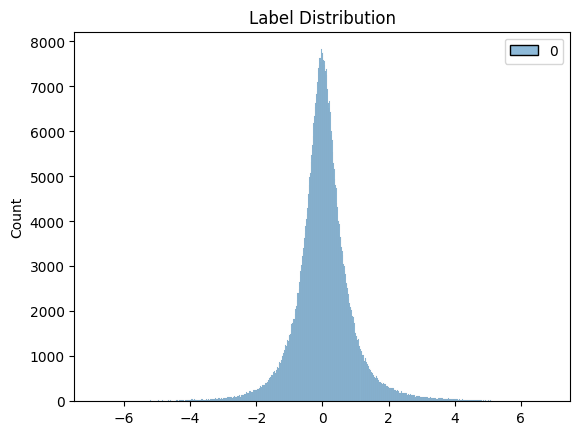

In [5]:
sns.histplot(train_df.select("label").collect().to_numpy())
plt.xlim([-7.5, 7.5])
plt.title("Label Distribution")

In [6]:
print(train_df.select("label").quantile(0.25, "nearest").collect().item(), train_df.select("label").quantile(0.75, "nearest").collect().item())

-0.3815825345619924 0.4341385161847758


In [7]:
# drop timestamp since test data does not have timestamp
train_df = train_df.drop("timestamp")

In [8]:
# Check for nas in train or test
temp = train_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col

[]

In [9]:
temp = test_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col
# no nas issue in train and test

[]

In [10]:
# check all possible datatypes
print(set(train_df.dtypes))

{Float64}


/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/1737341288.py:2: PerformanceWarning: Determining the data types of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().dtypes()` to get the data types without this warning.
  print(set(train_df.dtypes))


In [11]:
# check for possible constant columns
constant_columns = []
for col in train_df.columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        constant_columns.append(col)
print(constant_columns)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/2295361549.py:3: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col in train_df.columns:


['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


In [12]:
# check if same issue might also appear in test
actual_constant_columns = []
for col in constant_columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        actual_constant_columns.append(col)
print(set(constant_columns) - set(actual_constant_columns)) # all are constant => can remove?

set()


In [13]:
train_df = train_df.drop(actual_constant_columns)

In [14]:
# # get columns pair that is perfectly (or very highly) correlated
# correlated_pair = []
# col_names = train_df.collect_schema().names()
# for i in tqdm(range(len(col_names) - 1)):
#     col1 = col_names[i]
#     if col1 not in constant_columns:
#         for j in range(i + 1, len(col_names)):
#             col2 = col_names[j]
#             if col2 not in constant_columns:
#                 x = train_df.select(col1).collect()[col1].to_numpy()
#                 y = train_df.select(col2).collect()[col2].to_numpy()
#                 if np.corrcoef(x, y)[0][1] == 1:
#                     correlated_pair.append(f"{col1}-{col2}")
# print(correlated_pair)
# print(len(correlated_pair))

In [15]:
correlated_pair = ['X62-X104', 'X62-X146', 'X74-X116', 'X74-X158', 'X86-X128', 'X86-X170', 'X92-X134', 'X92-X176', 'X98-X140', 'X98-X182', 'X104-X146', 'X116-X158', 'X128-X170', 'X134-X176', 'X140-X182', 'X315-X357', 'X315-X399', 'X321-X363', 'X321-X405', 'X327-X369', 'X327-X411', 'X333-X375', 'X333-X417', 'X339-X381', 'X339-X423', 'X357-X399', 'X363-X405', 'X369-X411', 'X375-X417', 'X381-X423']
actual_correlated_pair = []
for cp in correlated_pair:
    col1, col2 = cp.split("-")
    x = test_df.select(col1).collect()[col1].to_numpy()
    y = test_df.select(col2).collect()[col2].to_numpy()
    if np.corrcoef(x, y)[0][1] == 1:
        actual_correlated_pair.append(f"{col1}-{col2}")
set(correlated_pair) - set(actual_correlated_pair)

{'X140-X182', 'X321-X363', 'X321-X405', 'X363-X405', 'X98-X140', 'X98-X182'}

In [16]:
# Group into correlated group
correlated_group = []
for cp in actual_correlated_pair:
    cp_lst = cp.split("-")
    added = False
    for inx, cg in enumerate(correlated_group):
        for var in cp_lst:
            if var in cg:
                correlated_group[inx].extend(cp_lst)
                correlated_group[inx] = list(set(correlated_group[inx]))
                added = True
                break
        if added:
            break
    if not added:
        correlated_group.append(cp_lst)
correlated_group
# 8 groups of perfectly correlated features, try to check if same things happen in test

[['X62', 'X104', 'X146'],
 ['X74', 'X116', 'X158'],
 ['X86', 'X128', 'X170'],
 ['X134', 'X92', 'X176'],
 ['X357', 'X399', 'X315'],
 ['X327', 'X369', 'X411'],
 ['X333', 'X417', 'X375'],
 ['X381', 'X423', 'X339']]

In [17]:
removed_col = []
for cg in correlated_group:
    removed_col.extend(cg[1:])
train_df = train_df.drop(removed_col)

In [18]:
# Incremental PCA
inc_PCA = IncrementalPCA(n_components = 50)

# fitting a batch every turn
n_rows = train_df.select("bid_qty").count().collect()[0, 0]
batch_size = 10000
for i in tqdm(range(0, n_rows, batch_size)):
    length = min(n_rows - i, batch_size)
    train_df_batch = train_df.drop("label").slice(offset = i, length = length).collect()
    inc_PCA.partial_fit(train_df_batch)

100%|██████████| 53/53 [00:48<00:00,  1.10it/s]


<Axes: >

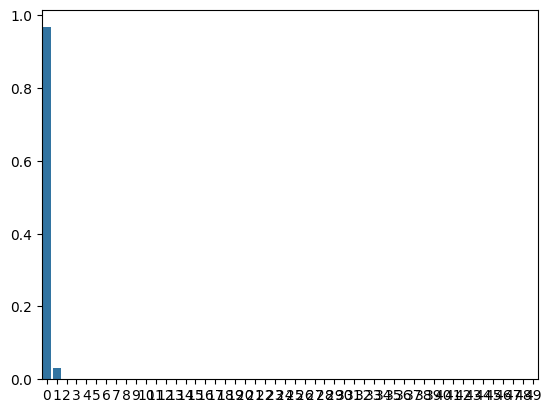

In [19]:
sns.barplot(inc_PCA.explained_variance_ratio_)

In [20]:
pc1_component = pd.DataFrame(
    {
        "var": inc_PCA.feature_names_in_,
        "pc1_contribution": inc_PCA.components_[0]
    }
)

pc1_component = pc1_component.sort_values("pc1_contribution", ascending=False, key = lambda x: abs(x)).reset_index().drop("index", axis = 1)
pc1_component

,var,pc1_contribution
0,volume,8.164894e-01
1,sell_qty,4.101512e-01
2,buy_qty,4.063382e-01
3,bid_qty,-1.431198e-03
4,ask_qty,-1.376846e-03
...,...,...
847,X263,2.643780e-07
848,X234,2.462031e-07
849,X791,2.012033e-07
850,X347,1.812320e-08


In [21]:
# Use the top 50 features
print(pc1_component.iloc[:50, ]["var"].tolist())

['volume', 'sell_qty', 'buy_qty', 'bid_qty', 'ask_qty', 'X596', 'X594', 'X877', 'X879', 'X597', 'X880', 'X595', 'X878', 'X544', 'X551', 'X558', 'X873', 'X117', 'X565', 'X882', 'X153', 'X123', 'X111', 'X502', 'X495', 'X75', 'X881', 'X509', 'X394', 'X141', 'X147', 'X388', 'X87', 'X99', 'X352', 'X105', 'X876', 'X346', 'X572', 'X451', 'X81', 'X69', 'X452', 'X516', 'X177', 'X480', 'X456', 'X135', 'X883', 'X406']


In [22]:
# Also need to check correlation with target variable
var_label_correlation = []
for i in tqdm(range(pc1_component.shape[0])):
    var = pc1_component.loc[i, "var"]
    var_label_correlation.append(train_df.select(pl.corr(var, "label")).collect().item())
pc1_component["var_label_correlation"] = var_label_correlation
pc1_component

100%|██████████| 852/852 [00:00<00:00, 2037.08it/s]


,var,pc1_contribution,var_label_correlation
0,volume,8.164894e-01,0.008809
1,sell_qty,4.101512e-01,0.011166
2,buy_qty,4.063382e-01,0.005618
3,bid_qty,-1.431198e-03,-0.013220
4,ask_qty,-1.376846e-03,-0.015762
...,...,...,...
847,X263,2.643780e-07,0.012352
848,X234,2.462031e-07,0.004803
849,X791,2.012033e-07,0.001805
850,X347,1.812320e-08,-0.010130


In [23]:
pc1_component.sort_values("var_label_correlation", ascending=False, key = lambda x: abs(x))

,var,pc1_contribution,var_label_correlation
430,X21,0.000022,0.069401
416,X20,0.000024,0.067667
219,X28,0.000049,0.064092
496,X863,-0.000017,0.064057
202,X29,0.000052,0.062339
...,...,...,...
447,X795,-0.000021,-0.000185
265,X86,-0.000042,0.000120
121,X475,0.000079,-0.000063
13,X544,-0.000322,-0.000042


In [24]:
pc1_component["pc1_contribution_rnk"] = pc1_component["pc1_contribution"].abs().rank(method = "min", ascending=False)
pc1_component["var_label_correlation_rnk"] = pc1_component["var_label_correlation"].abs().rank(method = "min", ascending=False)
pc1_component["average_rnk"] = (pc1_component["pc1_contribution_rnk"] + pc1_component["var_label_correlation_rnk"]) / 2
pc1_component

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,volume,8.164894e-01,0.008809,1.0,603.0,302.0
1,sell_qty,4.101512e-01,0.011166,2.0,538.0,270.0
2,buy_qty,4.063382e-01,0.005618,3.0,697.0,350.0
3,bid_qty,-1.431198e-03,-0.013220,4.0,478.0,241.0
4,ask_qty,-1.376846e-03,-0.015762,5.0,402.0,203.5
...,...,...,...,...,...,...
847,X263,2.643780e-07,0.012352,848.0,502.0,675.0
848,X234,2.462031e-07,0.004803,849.0,722.0,785.5
849,X791,2.012033e-07,0.001805,850.0,804.0,827.0
850,X347,1.812320e-08,-0.010130,851.0,571.0,711.0


In [25]:
popular_var = [
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]
pc1_component[pc1_component["var"].isin(popular_var)]

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,volume,0.816489,0.008809,1.0,603.0,302.0
1,sell_qty,0.410151,0.011166,2.0,538.0,270.0
2,buy_qty,0.406338,0.005618,3.0,697.0,350.0
3,bid_qty,-0.001431,-0.013220,4.0,478.0,241.0
4,ask_qty,-0.001377,-0.015762,5.0,402.0,203.5
133,X345,-0.000076,-0.011439,134.0,527.0,330.5
165,X137,-0.000060,-0.044290,166.0,51.0,108.5
186,X862,0.000057,0.040828,187.0,65.0,126.0
329,X344,0.000032,-0.009061,330.0,597.0,463.5
354,X855,0.000029,0.037702,355.0,88.0,221.5


In [26]:
pc1_component = pc1_component.sort_values("average_rnk").reset_index().drop("index", axis = 1)
pc1_component

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,X473,1.494224e-04,0.040200,54.0,73.0,63.5
1,X451,1.803425e-04,0.035329,40.0,106.0,73.0
2,X111,-2.361445e-04,0.033087,23.0,126.0,74.5
3,X153,-2.469401e-04,0.032990,21.0,128.0,74.5
4,X205,1.427800e-04,0.036817,59.0,97.0,78.0
...,...,...,...,...,...,...
847,X101,-1.208361e-06,-0.001161,827.0,817.0,822.0
848,X78,1.253917e-06,0.000942,826.0,823.0,824.5
849,X791,2.012033e-07,0.001805,850.0,804.0,827.0
850,X790,-6.532211e-07,-0.001051,840.0,820.0,830.0


In [27]:
best_pc1_contribution = pc1_component[pc1_component["pc1_contribution_rnk"] <= 200]["var"].tolist()
with open("features/best_pc1_contribution.pkl", "wb") as f:
    pickle.dump(best_pc1_contribution, f)

In [28]:
best_label_correlation = pc1_component[pc1_component["var_label_correlation_rnk"] <= 100]["var"].tolist()
with open("features/best_label_correlation.pkl", "wb") as f:
    pickle.dump(best_label_correlation, f)

In [29]:
best_overall = (pc1_component.loc[:50, "var"].to_list())
best_overall.extend(["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"])
with open("features/best_overall.pkl", "wb") as f:
    pickle.dump(best_overall, f)

Analyze interesting features from initial modeling

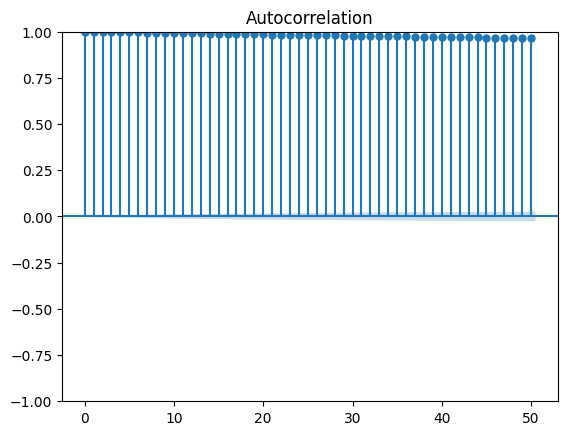

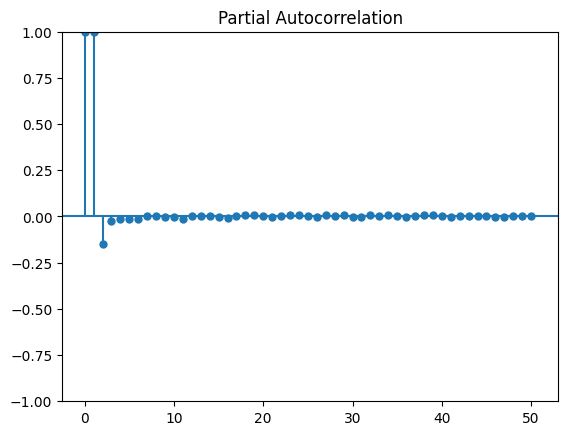

In [30]:
plot_acf(train_df.select("X198").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X198").collect().to_numpy(), lags=50)
plt.show()

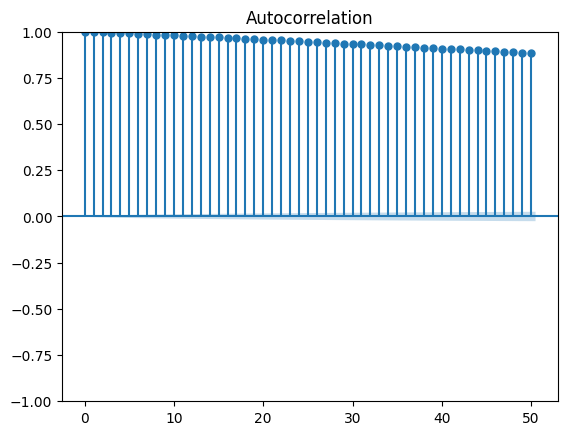

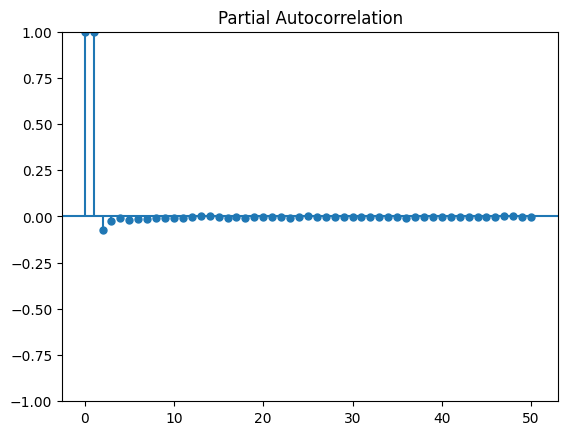

In [31]:
plot_acf(train_df.select("X598").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X598").collect().to_numpy(), lags=50)
plt.show()

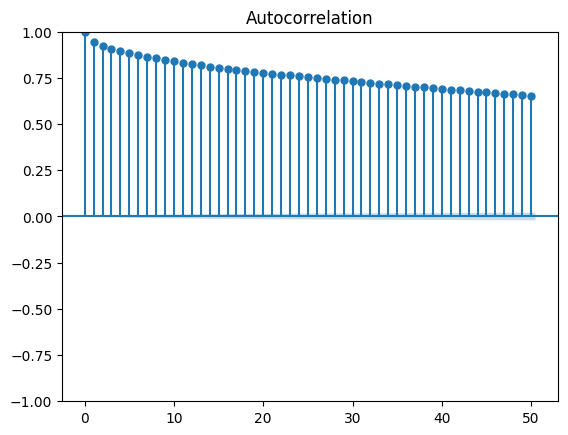

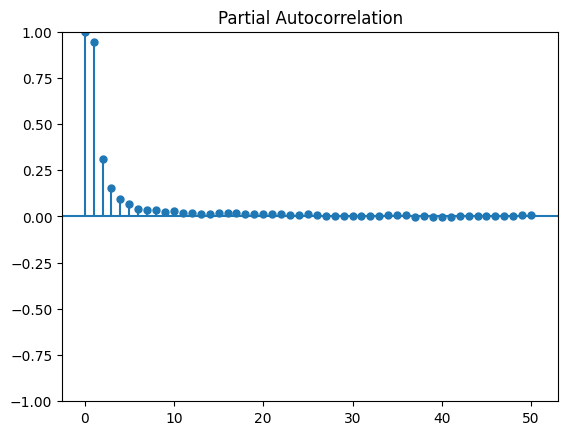

In [32]:
plot_acf(train_df.select("X863").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X863").collect().to_numpy(), lags=50)
plt.show()

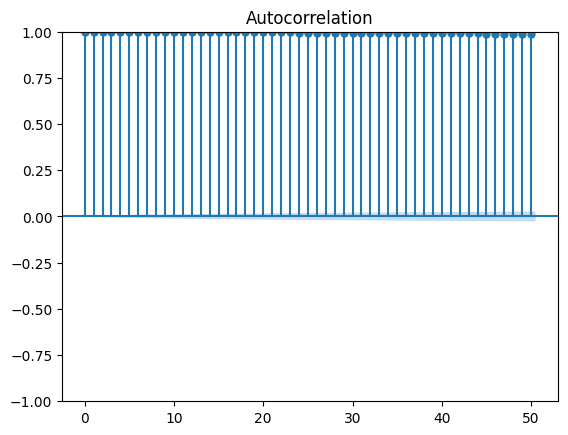

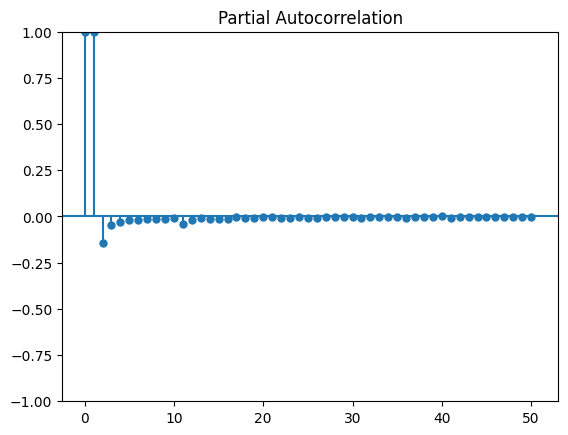

In [33]:
plot_acf(train_df.select("X466").collect().to_numpy(), lags=50)
plot_pacf(train_df.select("X466").collect().to_numpy(), lags=50)
plt.show()

Add extra features

In [34]:
train_df = train_df.with_columns(
    # interaction features
    (pl.col("bid_qty") * pl.col("ask_qty")).alias("bid_ask_interaction"),
    (pl.col("bid_qty") * pl.col("buy_qty")).alias("bid_buy_interaction"),
    (pl.col("bid_qty") * pl.col("sell_qty")).alias("bid_sell_interaction"),
    (pl.col("ask_qty") * pl.col("buy_qty")).alias("ask_buy_interaction"),
    (pl.col("ask_qty") * pl.col("sell_qty")).alias("ask_sell_interaction"),
    (pl.col("buy_qty") * pl.col("sell_qty")).alias("buy_sell_interaction"),

    # spread features
    ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("ask_qty") + pl.col("bid_qty")) + 1e-8).alias("spread_indicator"),

    # volume weighted features
    (pl.col("buy_qty") * pl.col("volume")).alias("volume_weighted_buy"),
    (pl.col("sell_qty") * pl.col("volume")).alias("volume_weighted_sell"),
    (pl.col("bid_qty") * pl.col("volume")).alias("volume_weighted_bid"),
    (pl.col("ask_qty") * pl.col("volume")).alias("volume_weighted_ask"),

    # buy/sell and bid/ask ratios
    (pl.col("buy_qty") / (pl.col("sell_qty") + 1e-8)).alias("buy_sell_ratio"),
    (pl.col("bid_qty") / (pl.col("ask_qty") + 1e-8)).alias("bid_ask_ratio"),

    # order flow imbalance
    ((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)).alias("order_flow_imbalance"),

    # buying and selling pressure
    (pl.col("buy_qty") / (pl.col("volume") + 1e-8)).alias("buying_pressure"),
    (pl.col("sell_qty") / (pl.col("volume") + 1e-8)).alias("selling_pressure"),

    # liquidity features
    (pl.col("bid_qty") + pl.col("ask_qty")).alias("total_liquidity"),
    ((pl.col("bid_qty") - pl.col("ask_qty")) / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("liquidity_imbalance"),
    ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("volume") + 1e-8)).alias("relative_spread"),

    # trade related features (size, intensity, flow)
    ((pl.col("buy_qty") + pl.col("sell_qty")) / (pl.col("volume") + 1e-8)).alias("trade_intensity"),
    (pl.col("volume") / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("avg_trade_size"),
    ((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("net_trade_flow"),

    # volume features in market + how market is working wrt to volume 
    ((pl.col("bid_qty") + pl.col("ask_qty")) / (pl.col("volume") + 1e-8)).alias("depth_ratio"),
    ((pl.col("buy_qty") + pl.col("sell_qty")) / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("volume_participation"),
    (pl.col("volume") * (pl.col("bid_qty") + pl.col("ask_qty"))).alias("market_activity"),

    # spread proxy and realized vol proxy
    ((pl.col("buy_qty") - pl.col("sell_qty")).abs() / (pl.col("volume") + 1e-8)).alias("effective_spread_proxy"),
    (((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)) * pl.col("volume")).alias("realized_volatility_proxy"),

    # normalized buy/sell volume
    (pl.col("buy_qty") / (pl.col("bid_qty") + 1e-8)).alias("normalized_buy_volume"),
    (pl.col("sell_qty") / (pl.col("ask_qty") + 1e-8)).alias("normalized_sell_volume"),

    # imbalance and spread interaction
    (((pl.col("buy_qty") - pl.col("sell_qty")) / (pl.col("volume") + 1e-8)) * ((pl.col("bid_qty") + pl.col("ask_qty")) / (pl.col("volume") + 1e-8))).alias("liquidity_adjusted_imbalance"),
    ((pl.col("buy_qty") / (pl.col("volume") + 1e-8)) * ((pl.col("ask_qty") - pl.col("bid_qty")) / (pl.col("ask_qty") + pl.col("bid_qty")) + 1e-8)).alias("pressure_spread_interaction"),

    # trade direction ratio, net buying volume, bid/ask skew
    (pl.col("buy_qty") / (pl.col("buy_qty") + pl.col("sell_qty") + 1e-8)).alias("trade_direction_ratio"),
    (pl.col("buy_qty") - pl.col("sell_qty")).alias("net_buy_volume"),
    (pl.col("bid_qty") / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("bid_skew"),
    (pl.col("ask_qty") / (pl.col("bid_qty") + pl.col("ask_qty") + 1e-8)).alias("ask_skew")
)

train_df = train_df.fill_nan(0).fill_null(0)

Test important features on lags with other columns to reverse-engineer anonymized features

In [35]:
interested_time = [
    1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 
    35, 40, 45, 50, 55, 60, 
    120, 180, 240, 300, 360, 720, 1440, 
    1440 * 3, 1440 * 5, 1440 * 7, 1440 * 14, 
    1440 * 30, 1440 * 60, 1440 * 90, 1440 * 180
]

In [36]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X466"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X466", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/1252193341.py:5: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():


1
total_liquidity -0.18559817543739174 0.18559817543739174
2
total_liquidity -0.22252237267040526 0.22252237267040526
3
total_liquidity -0.24345959416230853 0.24345959416230853
4
total_liquidity -0.2579982116188962 0.2579982116188962
5
total_liquidity -0.26917661040373503 0.26917661040373503
10
total_liquidity -0.30309557951782923 0.30309557951782923
15
total_liquidity -0.32124267445289534 0.32124267445289534
20
total_liquidity -0.33317881487574 0.33317881487574
25
total_liquidity -0.34201494449244185 0.34201494449244185
30
total_liquidity -0.3490396863271738 0.3490396863271738
35
total_liquidity -0.35465402270560464 0.35465402270560464
40
total_liquidity -0.35926736266788284 0.35926736266788284
45
total_liquidity -0.363203932017457 0.363203932017457
50
total_liquidity -0.36662391582116066 0.36662391582116066
55
total_liquidity -0.3696334574106142 0.3696334574106142
60
total_liquidity -0.37230767410695753 0.37230767410695753
120
total_liquidity -0.3913038233415288 0.3913038233415288
18

In [37]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X198"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X198", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/3767230933.py:5: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():


1
buy_qty 0.08222562963949438 0.08222562963949438
2
buy_qty 0.09225161863083188 0.09225161863083188
3
buy_qty 0.09847527390721926 0.09847527390721926
4
buy_qty 0.10308461636332526 0.10308461636332526
5
buy_qty 0.10672126405713353 0.10672126405713353
10
net_buy_volume 0.1254002661319277 0.1254002661319277
15
net_buy_volume 0.14954553666219011 0.14954553666219011
20
net_buy_volume 0.16887976365667648 0.16887976365667648
25
net_buy_volume 0.18522721572377773 0.18522721572377773
30
net_buy_volume 0.1993576129563989 0.1993576129563989
35
net_buy_volume 0.21199878715636516 0.21199878715636516
40
net_buy_volume 0.2233901803869504 0.2233901803869504
45
net_buy_volume 0.23377698836526944 0.23377698836526944
50
net_buy_volume 0.2433439052745406 0.2433439052745406
55
net_buy_volume 0.2522403265311886 0.2522403265311886
60
net_buy_volume 0.26045775264844584 0.26045775264844584
120
net_buy_volume 0.3326730372988125 0.3326730372988125
180
net_buy_volume 0.3810718693414011 0.3810718693414011
240
net_

In [38]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X598"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X598", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/3840519081.py:5: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():


1
label 0.057587693330472756 0.057587693330472756
2
label 0.05953550730392046 0.05953550730392046
3
label 0.06139455829788479 0.06139455829788479
4
label 0.0631971445029285 0.0631971445029285
5
label 0.06496800659554249 0.06496800659554249
10
realized_volatility_proxy 0.0768272857249509 0.0768272857249509
15
realized_volatility_proxy 0.08853734091047481 0.08853734091047481
20
realized_volatility_proxy 0.09819426076000633 0.09819426076000633
25
realized_volatility_proxy 0.10649294997639525 0.10649294997639525
30
realized_volatility_proxy 0.11348283961319233 0.11348283961319233
35
realized_volatility_proxy 0.11968840269819435 0.11968840269819435
40
realized_volatility_proxy 0.12541322414688058 0.12541322414688058
45
realized_volatility_proxy 0.1307634600752455 0.1307634600752455
50
realized_volatility_proxy 0.1357720480380861 0.1357720480380861
55
label 0.14266278211368552 0.14266278211368552
60
label 0.14961402010175084 0.14961402010175084
120
label 0.22685267693664368 0.226852676936643

In [39]:
for l in interested_time:
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    for col in train_df.schema.keys():
        if "X" not in col:
            corr = train_df.with_columns(
                pl.col("X862"),
                pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
            ).with_row_index("row_inx").select(pl.corr(f"X862", f"{col}_rolling_{l}")).collect().item()
            if abs(corr) > max_abs_correlation:
                max_abs_correlation = abs(corr)
                max_correlation = corr
                feature = col
    print(l)
    print(feature, max_correlation, max_abs_correlation)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/1311669880.py:5: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():


1
total_liquidity -0.18661374692120816 0.18661374692120816
2
total_liquidity -0.22374617431867622 0.22374617431867622
3
total_liquidity -0.2447963207438299 0.2447963207438299
4
total_liquidity -0.259411872000682 0.259411872000682
5
total_liquidity -0.27065116243025467 0.27065116243025467
10
total_liquidity -0.30480024333064965 0.30480024333064965
15
total_liquidity -0.3230785544267201 0.3230785544267201
20
total_liquidity -0.33511604575035114 0.33511604575035114
25
total_liquidity -0.3440488879084439 0.3440488879084439
30
total_liquidity -0.3511312959498164 0.3511312959498164
35
total_liquidity -0.35681561395390254 0.35681561395390254
40
total_liquidity -0.36151598817291547 0.36151598817291547
45
total_liquidity -0.36555978629259595 0.36555978629259595
50
total_liquidity -0.3690911193751226 0.3690911193751226
55
total_liquidity -0.3721988793444021 0.3721988793444021
60
total_liquidity -0.37496707105736865 0.37496707105736865
120
total_liquidity -0.3944885541078022 0.3944885541078022
18

In [40]:
features = ['X862', 'X598', 'X863', 'X533', 'X379', 'X856', 'X28', 'X284', 'X466', 'X95', 
            'X331', 'X465', 'X852', 'X861', 'X198', 'X169', 'X285', 'X23', 'X531', 'X444', 
            'X754', 'X445', 'X758', 'X137', 'X279', 'X540', 'X31', 'X218', 'X291', 'X511']
for f in features:
    print(f)
    max_correlation = 0
    max_abs_correlation = 0
    feature = None
    lag = None
    for l in tqdm(interested_time):
        for col in train_df.schema.keys():
            if "X" not in col:
                corr = train_df.with_columns(
                    pl.col(f),
                    pl.col(col).rolling_mean(window_size=l).shift(1).alias(f"{col}_rolling_{l}"),
                ).with_row_index("row_inx").select(pl.corr(f, f"{col}_rolling_{l}")).collect().item()
                if abs(corr) > max_abs_correlation:
                    max_abs_correlation = abs(corr)
                    max_correlation = corr
                    feature = col
                    lag = l
    print(feature, lag, max_correlation, max_abs_correlation)

X862


  0%|          | 0/31 [00:00<?, ?it/s]/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/4143730350.py:11: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for col in train_df.schema.keys():
100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


label 43200 0.752956962613657 0.752956962613657
X598


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


label 720 0.4336704912223768 0.4336704912223768
X863


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


buying_pressure 240 -0.12926205141297342 0.12926205141297342
X533


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


label 720 -0.46346376023263774 0.46346376023263774
X379


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


label 43200 -0.2545143866132977 0.2545143866132977
X856


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


label 720 0.3289790911976938 0.3289790911976938
X28


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


label 240 -0.09514821943205982 0.09514821943205982
X284


100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


label 129600 -0.47027645422236286 0.47027645422236286
X466


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


bid_sell_interaction 129600 -0.5702480641358628 0.5702480641358628
X95


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


label 1440 -0.6962819018093047 0.6962819018093047
X331


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


label 129600 -0.3676957752741178 0.3676957752741178
X465


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


label 1440 0.5766768740839422 0.5766768740839422
X852


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


label 86400 0.4293860658831594 0.4293860658831594
X861


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


label 720 0.6395314157002474 0.6395314157002474
X198


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


selling_pressure 1440 -0.7038026796836842 0.7038026796836842
X169


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


label 360 0.6916437422847159 0.6916437422847159
X285


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


label 1440 -0.3946823164483994 0.3946823164483994
X23


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


label 360 -0.3486872024617024 0.3486872024617024
X531


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


label 720 -0.45294793526454685 0.45294793526454685
X444


100%|██████████| 31/31 [00:15<00:00,  2.06it/s]


volume_weighted_bid 129600 -0.6226559329838353 0.6226559329838353
X754


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


label 720 -0.49123452436643006 0.49123452436643006
X445


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


volume_weighted_bid 129600 -0.7034253224898332 0.7034253224898332
X758


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


label 1440 -0.530718848469241 0.530718848469241
X137


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


label 1440 -0.716372349538305 0.716372349538305
X279


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


label 1440 -0.33201720860870954 0.33201720860870954
X540


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


label 720 -0.47376087721122 0.47376087721122
X31


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


label 720 -0.17905821814643058 0.17905821814643058
X218


100%|██████████| 31/31 [00:14<00:00,  2.15it/s]


net_buy_volume 720 0.861936377683199 0.861936377683199
X291


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


label 129600 -0.41823599617927165 0.41823599617927165
X511


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]

label 240 -0.37760699844847595 0.37760699844847595


Consider the case of different class of returns

In [41]:
print(train_df.select("label").quantile(1/3, "nearest").collect().item())

-0.226433977334199


In [42]:
def check_quantile(x):
    if x > 0.2: return "pos"
    elif x < -0.2: return "neg"
    return "neu"

In [43]:
valid = []
valid_col = [col for col in train_df.schema.keys() if "X" in col]
for col in tqdm(valid_col):
    data = train_df.select([pl.col(col), pl.col("label")]).collect().to_pandas()
    data["label"] = data["label"].apply(lambda x: check_quantile(x))
    # levene test for equal variance
    pos = data[data["label"] == "pos"][col].tolist()
    neg = data[data["label"] == "neg"][col].tolist()
    neu = data[data["label"] == "neu"][col].tolist()
    _, pvalue= levene(pos, neg, neu)
    if pvalue < 0.05:
        # do anova test later
        _, pvalue = f_oneway(pos, neg, neu)
        if pvalue < 0.05:
            valid.append(col)
print(len(valid))

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/2384857800.py:2: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  valid_col = [col for col in train_df.schema.keys() if "X" in col]
100%|██████████| 847/847 [01:46<00:00,  7.93it/s]

830


In [46]:
valid

['X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'X24',
 'X25',
 'X26',
 'X27',
 'X28',
 'X29',
 'X30',
 'X31',
 'X32',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X57',
 'X58',
 'X59',
 'X60',
 'X61',
 'X62',
 'X63',
 'X64',
 'X65',
 'X66',
 'X67',
 'X68',
 'X69',
 'X70',
 'X71',
 'X72',
 'X73',
 'X74',
 'X75',
 'X76',
 'X77',
 'X78',
 'X79',
 'X80',
 'X81',
 'X82',
 'X83',
 'X84',
 'X85',
 'X86',
 'X87',
 'X88',
 'X89',
 'X90',
 'X91',
 'X93',
 'X95',
 'X96',
 'X97',
 'X98',
 'X99',
 'X100',
 'X101',
 'X102',
 'X103',
 'X105',
 'X106',
 'X107',
 'X108',
 'X109',
 'X110',
 'X111',
 'X112',
 'X113',
 'X114',
 'X115',
 'X117',
 'X118',
 'X119',
 'X120',
 'X121',
 'X122',
 'X123',
 'X124',
 'X125',
 'X126',
 'X127',

In [44]:
popular_cols = [c for c in train_df.schema.keys() if "X" not in c and "label" not in c]
popular_valid = []
for col in tqdm(popular_cols):
    data = train_df.select([pl.col(col), pl.col("label")]).collect().to_pandas()
    data["label"] = data["label"].apply(lambda x: check_quantile(x))
    # levene test for equal variance
    pos = data[data["label"] == "pos"][col].tolist()
    neg = data[data["label"] == "neg"][col].tolist()
    neu = data[data["label"] == "neu"][col].tolist()
    _, pvalue= levene(pos, neg, neu)
    if pvalue < 0.05:
        # do anova test later
        _, pvalue = f_oneway(pos, neg, neu)
        if pvalue < 0.05:
            popular_valid.append(col)
print(len(popular_valid))

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/730969480.py:1: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  popular_cols = [c for c in train_df.schema.keys() if "X" not in c and "label" not in c]
100%|██████████| 40/40 [00:05<00:00,  7.59it/s]

40


Maybe try to clustering features to look at how features correlated to each other

In [95]:
# we have about 900 rows for 900 features, we might only look at a subset of data to prevent too large data
# use around 7 days (60 * 24 * 7 = 10080) to prevent too much data
X = train_df.slice(offset = 0, length = 10080).collect().to_numpy().T
for i in range(X.shape[0]):
    if np.linalg.norm(X[i, :]) == 0:
        X[i, :] += 1e-10

In [96]:
distance_matrix = pdist(X, metric='cosine')  
linkage_matrix = linkage(distance_matrix, method='median') 

In [97]:
clusters = fcluster(linkage_matrix, t=50, criterion='maxclust')
clusters_df = pd.DataFrame({
    "var": list(train_df.schema.keys()),
    "cluster": clusters
})
clusters_df

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/969486510.py:3: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  "var": list(train_df.schema.keys()),


,var,cluster
0,bid_qty,33
1,ask_qty,33
2,buy_qty,33
3,sell_qty,33
4,volume,33
...,...,...
883,pressure_spread_interaction,2
884,trade_direction_ratio,33
885,net_buy_volume,27
886,bid_skew,33


In [98]:
clusters_df["cluster"].value_counts()

cluster
33    391
28     91
42     75
29     67
32     34
38     32
12     29
3      16
20     12
30      9
21      8
13      8
18      8
37      7
11      7
36      7
26      7
22      6
5       6
24      5
41      4
19      4
23      4
25      4
35      4
1       4
40      4
31      3
2       3
46      3
14      3
17      3
10      3
15      2
4       2
27      2
45      1
16      1
39      1
44      1
43      1
34      1
6       1
47      1
8       1
9       1
7       1
Name: count, dtype: int64

In [99]:
clusters_df[clusters_df["cluster"] == 33]["var"].tolist()

['bid_qty',
 'ask_qty',
 'buy_qty',
 'sell_qty',
 'volume',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X25',
 'X26',
 'X27',
 'X28',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X57',
 'X59',
 'X62',
 'X63',
 'X65',
 'X68',
 'X69',
 'X71',
 'X74',
 'X75',
 'X77',
 'X80',
 'X81',
 'X83',
 'X84',
 'X85',
 'X86',
 'X87',
 'X89',
 'X90',
 'X91',
 'X93',
 'X95',
 'X96',
 'X97',
 'X98',
 'X99',
 'X101',
 'X105',
 'X107',
 'X110',
 'X111',
 'X113',
 'X117',
 'X119',
 'X122',
 'X123',
 'X125',
 'X126',
 'X129',
 'X131',
 'X132',
 'X134',
 'X135',
 'X137',
 'X138',
 'X140',
 'X141',
 'X143',
 'X147',
 'X149',
 'X152',
 'X153',
 'X155',
 'X159',
 'X161',
 'X164',
 'X165',
 'X167',
 'X171',
 'X173',
 'X177',
 'X179',
 'X182',
 'X183',

In [100]:
clusters_df[clusters_df["var"] == "label"]

,var,cluster
852,label,43


In [101]:
clusters_df[clusters_df["cluster"] == 43]

,var,cluster
852,label,43


In [102]:
X = train_df.slice(offset = 10080, length = 10080).collect().to_numpy().T
for i in range(X.shape[0]):
    if np.linalg.norm(X[i, :]) == 0:
        X[i, :] += 1e-10

In [103]:
distance_matrix = pdist(X, metric='cosine')  
linkage_matrix = linkage(distance_matrix, method='median') 

In [104]:
clusters = fcluster(linkage_matrix, t=50, criterion='maxclust')
clusters_df = pd.DataFrame({
    "var": list(train_df.schema.keys()),
    "cluster": clusters
})
clusters_df

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/969486510.py:3: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  "var": list(train_df.schema.keys()),


,var,cluster
0,bid_qty,18
1,ask_qty,18
2,buy_qty,16
3,sell_qty,16
4,volume,16
...,...,...
883,pressure_spread_interaction,5
884,trade_direction_ratio,18
885,net_buy_volume,44
886,bid_skew,18


In [105]:
clusters_df["cluster"].value_counts()

cluster
23    146
18    108
39     94
24     89
22     82
40     49
37     45
28     30
17     26
21     21
36     16
32     12
31     12
33     12
16     11
19      9
2       8
43      8
35      7
41      7
7       7
20      7
34      6
9       6
42      6
30      6
29      6
38      4
14      4
12      4
15      4
1       4
13      4
45      3
11      3
5       3
6       2
44      2
10      2
25      2
26      2
27      2
47      1
8       1
4       1
3       1
48      1
49      1
46      1
Name: count, dtype: int64

In [106]:
clusters_df[clusters_df["cluster"] == 23]["var"].tolist()

['X59',
 'X62',
 'X65',
 'X68',
 'X71',
 'X74',
 'X77',
 'X80',
 'X83',
 'X86',
 'X89',
 'X95',
 'X98',
 'X101',
 'X107',
 'X110',
 'X113',
 'X119',
 'X122',
 'X125',
 'X131',
 'X134',
 'X137',
 'X140',
 'X143',
 'X149',
 'X152',
 'X155',
 'X161',
 'X164',
 'X167',
 'X173',
 'X179',
 'X182',
 'X238',
 'X239',
 'X240',
 'X245',
 'X246',
 'X247',
 'X264',
 'X265',
 'X266',
 'X267',
 'X268',
 'X269',
 'X270',
 'X271',
 'X273',
 'X274',
 'X275',
 'X276',
 'X277',
 'X278',
 'X279',
 'X280',
 'X281',
 'X282',
 'X283',
 'X284',
 'X285',
 'X306',
 'X307',
 'X309',
 'X312',
 'X313',
 'X318',
 'X319',
 'X321',
 'X324',
 'X325',
 'X327',
 'X330',
 'X331',
 'X333',
 'X336',
 'X337',
 'X342',
 'X343',
 'X345',
 'X348',
 'X351',
 'X354',
 'X357',
 'X360',
 'X363',
 'X366',
 'X372',
 'X378',
 'X381',
 'X384',
 'X387',
 'X390',
 'X393',
 'X396',
 'X402',
 'X405',
 'X408',
 'X414',
 'X420',
 'X426',
 'X429',
 'X430',
 'X431',
 'X432',
 'X433',
 'X434',
 'X435',
 'X436',
 'X437',
 'X438',
 'X485',
 'X48

In [107]:
clusters_df[clusters_df["cluster"] == 18]["var"].tolist()

['bid_qty',
 'ask_qty',
 'X17',
 'X25',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X84',
 'X90',
 'X96',
 'X168',
 'X174',
 'X180',
 'X184',
 'X185',
 'X187',
 'X188',
 'X190',
 'X191',
 'X415',
 'X421',
 'X427',
 'X593',
 'X639',
 'X642',
 'X645',
 'X648',
 'X651',
 'X654',
 'X657',
 'X660',
 'X662',
 'X663',
 'X665',
 'X666',
 'X668',
 'X669',
 'X671',
 'X672',
 'X674',
 'X675',
 'X677',
 'X678',
 'X680',
 'X681',
 'X683',
 'X684',
 'X686',
 'X687',
 'X689',
 'X690',
 'X692',
 'X693',
 'X695',
 'X696',
 'X853',
 'X854',
 'X861',
 'X865',
 'X875',
 'X876',
 'X877',
 'X878',
 'X879',
 'X880',
 'X881',
 'X882',
 'X883',
 'X884',
 'X885',
 'X886',
 'X887',
 'X888',
 'X889',
 'X890',
 'bid_ask_interaction',
 'buy_sell_ratio',
 'buying_pressure',
 'selling_pressure',
 'total_liquidity',
 'trade_intensity',
 'avg_trade_size',
 'depth_ratio',


In [108]:
clusters_df[clusters_df["var"] == "label"]

,var,cluster
852,label,47


In [109]:
X = train_df.slice(offset = 10080 * 28, length = 10080).collect().to_numpy().T
for i in range(X.shape[0]):
    if np.linalg.norm(X[i, :]) == 0:
        X[i, :] += 1e-10

In [110]:
distance_matrix = pdist(X, metric='cosine')  
linkage_matrix = linkage(distance_matrix, method='median') 

In [111]:
clusters = fcluster(linkage_matrix, t=50, criterion='maxclust')
clusters_df = pd.DataFrame({
    "var": list(train_df.schema.keys()),
    "cluster": clusters
})
clusters_df

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_2449/969486510.py:3: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  "var": list(train_df.schema.keys()),


,var,cluster
0,bid_qty,24
1,ask_qty,24
2,buy_qty,10
3,sell_qty,10
4,volume,10
...,...,...
883,pressure_spread_interaction,4
884,trade_direction_ratio,24
885,net_buy_volume,13
886,bid_skew,24


In [112]:
clusters_df["cluster"].value_counts()

cluster
32    135
20    110
36     86
24     71
31     60
19     44
17     42
34     31
6      31
15     27
28     26
3      19
27     16
11     16
7      16
8      16
33     16
18     16
16     14
12     10
42      8
10      8
43      7
38      7
39      7
1       4
9       4
26      4
41      4
14      3
40      3
25      3
13      2
2       2
4       2
21      2
30      2
29      2
44      1
37      1
23      1
47      1
50      1
35      1
48      1
46      1
5       1
22      1
49      1
45      1
Name: count, dtype: int64

In [114]:
clusters_df[clusters_df["cluster"] == 32]["var"].tolist()

['X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X57',
 'X59',
 'X63',
 'X65',
 'X69',
 'X71',
 'X75',
 'X77',
 'X81',
 'X87',
 'X93',
 'X99',
 'X101',
 'X105',
 'X107',
 'X111',
 'X113',
 'X117',
 'X119',
 'X123',
 'X129',
 'X135',
 'X141',
 'X143',
 'X147',
 'X149',
 'X153',
 'X155',
 'X159',
 'X161',
 'X165',
 'X171',
 'X177',
 'X183',
 'X186',
 'X189',
 'X238',
 'X239',
 'X240',
 'X245',
 'X246',
 'X247',
 'X248',
 'X249',
 'X250',
 'X251',
 'X252',
 'X253',
 'X254',
 'X255',
 'X256',
 'X257',
 'X258',
 'X259',
 'X260',
 'X261',
 'X262',
 'X263',
 'X265',
 'X266',
 'X267',
 'X268',
 'X273',
 'X274',
 'X275',
 'X276',
 'X304',
 'X306',
 'X310',
 'X312',
 'X316',
 'X318',
 'X322',
 'X324',
 'X328',
 'X330',
 'X334',
 'X340',
 'X346',
 'X348',
 'X352',
 'X354',
 'X358',
 'X360',
 'X364',
 'X366',
 'X370',
 'X376',
 'X382',
 'X388',
 'X390',
 'X394',
 'X396',
 'X400',
 'X402',
 'X406',
 'X408',
 'X412',
 'X418',
 '

In [115]:
clusters_df[clusters_df["cluster"] == 20]["var"].tolist()

['X61',
 'X67',
 'X73',
 'X79',
 'X85',
 'X103',
 'X109',
 'X115',
 'X121',
 'X127',
 'X145',
 'X151',
 'X157',
 'X163',
 'X192',
 'X193',
 'X194',
 'X195',
 'X196',
 'X197',
 'X198',
 'X199',
 'X200',
 'X201',
 'X202',
 'X203',
 'X204',
 'X205',
 'X206',
 'X207',
 'X208',
 'X209',
 'X210',
 'X211',
 'X212',
 'X213',
 'X214',
 'X215',
 'X216',
 'X217',
 'X218',
 'X219',
 'X220',
 'X221',
 'X222',
 'X223',
 'X224',
 'X225',
 'X226',
 'X227',
 'X228',
 'X229',
 'X230',
 'X231',
 'X232',
 'X233',
 'X308',
 'X314',
 'X320',
 'X326',
 'X350',
 'X356',
 'X362',
 'X368',
 'X392',
 'X398',
 'X404',
 'X410',
 'X439',
 'X440',
 'X441',
 'X442',
 'X446',
 'X447',
 'X448',
 'X449',
 'X453',
 'X454',
 'X455',
 'X456',
 'X460',
 'X461',
 'X462',
 'X463',
 'X467',
 'X468',
 'X469',
 'X470',
 'X474',
 'X475',
 'X476',
 'X477',
 'X718',
 'X719',
 'X720',
 'X721',
 'X722',
 'X723',
 'X724',
 'X725',
 'X726',
 'X727',
 'X728',
 'X729',
 'X730',
 'X731',
 'X848',
 'X849',
 'X850',
 'X851']